In [100]:
import os
from os import listdir
from os.path import isfile, join
from collections import Counter
import time
from scipy.stats import randint, uniform
from sklearn.utils.fixes import loguniform

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns
import missingno as msno
import pandas_profiling
from sklearn.metrics import roc_auc_score
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.linear_model import CoxnetSurvivalAnalysis

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from hyperopt.pyll.base import scope
import pyspark

import xgboost
import shap
shap.initjs()
import numpy as np
import pandas as pd
from random import sample 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pylab as pl

# Hyperparameters tuning

from hyperopt import STATUS_OK, fmin, hp, tpe, SparkTrials

# Some constants

SEED = 314159265
VALID_SIZE = 0.2
TARGET = 'outcome'

def c_statistic_harrell(pred, labels):
    total = 0
    matches = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if int(labels[j]) > 0 and abs(int(labels[i])) > int(labels[j]):
                total += 1
                if pred[j] > pred[i]:
                    matches += 1
    return matches/total

#-----------------------XGBoost--------------------------#

def score_xgb(params):
    print("Training with params: ")
    print(params)
    
    n_folds = 5
    val_scores = []
    skf = KFold(n_splits = n_folds, shuffle = False)
    num_boost_round=1000
    #k-fold CV stratified by study
    for train_index, val_index in skf.split(X_train): 
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        dtrain = xgboost.DMatrix(X_tr, label=y_tr)
        dval = xgboost.DMatrix(X_val, label=y_val)

        watchlist = [(dval, 'eval'), (dtrain, 'train')]
        gbm_model = xgboost.train(params, dtrain, num_boost_round,
                              evals=watchlist,
                              verbose_eval=250)
        
        predictions = gbm_model.predict(dval,
                                    ntree_limit=gbm_model.best_iteration + 1)
        val_scores.append(c_statistic_harrell(predictions, list(y_val)))
        
    score = np.mean(val_scores) #Objective: maximize mean 5-fold CV C-index 
    
    print("\tScore {0}\n\n".format(score))
    # The score function should return the loss (1-score)
    # since the optimize function looks for the minimum
    loss = 1 - score
    return {'loss': loss, 'status': STATUS_OK}


def optimize_xgb(score, 
             random_state=SEED):
    """
    This is the optimization function that given a space (space here) of 
    hyperparameters and a scoring function (score here), finds the best hyperparameters.
    """
    # XGB param ranges obtained from Barnwal A, Cho H, Hocking T (2020). Survival regression with accelerated failure time model in XGBoost: 
    # https://arxiv.org/pdf/2006.04920.pdf
    # exception: min_child_weight, reg_alpha and reg_lambda capped at 10 rather than 100
    space = {
        'eta':                         hp.loguniform('eta', np.log(0.001), np.log(1)),
        'max_depth':                   scope.int(hp.quniform('max_depth', 2,10,1)),
        'min_child_weight':            hp.loguniform('min_child_weight', np.log(0.001), np.log(10)),
        'reg_alpha':                   hp.loguniform('reg_alpha', np.log(0.001), np.log(10)),
        'reg_lambda':                  hp.loguniform('reg_lambda', np.log(0.001), np.log(10)),
        'subsample':                   hp.uniform('subsample', 0.75, 1),
        "objective": "survival:cox"
    }
    
    # Use the fmin function from Hyperopt to find the best hyperparameters
    best = fmin(score, space, algo=tpe.suggest, 
                max_evals=100)
#     trials = SparkTrials(parallelism = 4))
    return best

In [101]:
# Set working directory to save all figures (create directory beforehand)
save_to = save_to = os.getcwd() + '/'

In [102]:
#edit this to read xgb_SIMDATA.csv from whereever this file is located 
All_sim = pd.read_csv("xgb_SIMDATA.csv")
X_sim = All_sim.drop(columns = ['SURV_DAY_XGB'])
y_sim = All_sim['SURV_DAY_XGB']
y_sim.head()

0   -7675
1    7014
2   -4138
3    7143
4    1487
Name: SURV_DAY_XGB, dtype: int64

In [103]:
print(X_sim.shape)
X_sim.head()

(850, 3)


,coef1,coef2,coef3
0,1,1,0
1,0,0,0
2,0,1,1
3,1,1,0
4,0,0,1


In [104]:
X_sim

,coef1,coef2,coef3
0,1,1,0
1,0,0,0
2,0,1,1
3,1,1,0
4,0,0,1
...,...,...,...
845,0,0,0
846,1,1,0
847,1,1,1
848,1,0,1


In [105]:
X_train, X_test, y_train, y_test = train_test_split(X_sim, y_sim, test_size=0.2, random_state=20)
print("---- Running XGBoost ----")
start=time.time()
xgb_best_hyperparams = optimize_xgb(score_xgb)
end=time.time()
print("Done: took", (end-start)/60, "minutes")
print("---- Results for XGBoost ----")
print("The best hyperparameters are: ", "\n")
print(xgb_best_hyperparams)

---- Running XGBoost ----
Training with params:                                  
{'eta': 0.009662368913128813, 'max_depth': 9, 'min_child_weight': 0.0717783561980574, 'objective': 'survival:cox', 'reg_alpha': 0.5601535895482147, 'reg_lambda': 9.69709400191958, 'subsample': 0.8667995229571687}
[0]	eval-cox-nloglik:3.87139	train-cox-nloglik:5.31899 

[250]	eval-cox-nloglik:3.47739	train-cox-nloglik:4.85947

[500]	eval-cox-nloglik:3.42273	train-cox-nloglik:4.80639

[750]	eval-cox-nloglik:3.41042	train-cox-nloglik:4.79681

[999]	eval-cox-nloglik:3.40639	train-cox-nloglik:4.79475

[0]	eval-cox-nloglik:3.94933	train-cox-nloglik:5.29792 

[250]	eval-cox-nloglik:3.46449	train-cox-nloglik:4.85943

[500]	eval-cox-nloglik:3.40434	train-cox-nloglik:4.80837

[750]	eval-cox-nloglik:3.39116	train-cox-nloglik:4.79927

[999]	eval-cox-nloglik:3.38788	train-cox-nloglik:4.79743

[0]	eval-cox-nloglik:4.03568	train-cox-nloglik:5.27577 

[250]	eval-cox-nloglik:3.65439	train-cox-nloglik:4.80723

[500]	eval-c

[999]	eval-cox-nloglik:3.64854	train-cox-nloglik:4.73471                         

[0]	eval-cox-nloglik:3.78515	train-cox-nloglik:5.16158                           

[250]	eval-cox-nloglik:3.40121	train-cox-nloglik:4.79454                         

[500]	eval-cox-nloglik:3.40051	train-cox-nloglik:4.79456                         

[750]	eval-cox-nloglik:3.39838	train-cox-nloglik:4.79457                         

[999]	eval-cox-nloglik:3.39960	train-cox-nloglik:4.79455                         

[0]	eval-cox-nloglik:3.74310	train-cox-nloglik:5.17124                           

[250]	eval-cox-nloglik:3.37726	train-cox-nloglik:4.79957                         

[500]	eval-cox-nloglik:3.37669	train-cox-nloglik:4.79964                         

[750]	eval-cox-nloglik:3.37748	train-cox-nloglik:4.79962                         

[999]	eval-cox-nloglik:3.37747	train-cox-nloglik:4.79962                         

	Score 0.7259139159287745                                                        


Tra

[750]	eval-cox-nloglik:3.37581	train-cox-nloglik:4.80002                         

[999]	eval-cox-nloglik:3.37633	train-cox-nloglik:4.79969                         

	Score 0.7259139159287745                                                        


Training with params:                                                            
{'eta': 0.0013713753622411867, 'max_depth': 9, 'min_child_weight': 0.8894139495286011, 'objective': 'survival:cox', 'reg_alpha': 0.010813855966326785, 'reg_lambda': 0.787123563664349, 'subsample': 0.8305690277416904}
[0]	eval-cox-nloglik:3.87552	train-cox-nloglik:5.32392                           

[250]	eval-cox-nloglik:3.71439	train-cox-nloglik:5.11944                         

[500]	eval-cox-nloglik:3.62514	train-cox-nloglik:5.01564                         

[750]	eval-cox-nloglik:3.56716	train-cox-nloglik:4.95132                         

[999]	eval-cox-nloglik:3.52653	train-cox-nloglik:4.90787                         

[0]	eval-cox-nloglik:3.95425	train-c

[750]	eval-cox-nloglik:3.41410	train-cox-nloglik:4.79937                          

[999]	eval-cox-nloglik:3.40822	train-cox-nloglik:4.79557                          

[0]	eval-cox-nloglik:3.95008	train-cox-nloglik:5.29861                            

[250]	eval-cox-nloglik:3.48248	train-cox-nloglik:4.87695                          

[500]	eval-cox-nloglik:3.41253	train-cox-nloglik:4.81536                          

[750]	eval-cox-nloglik:3.39474	train-cox-nloglik:4.80166                          

[999]	eval-cox-nloglik:3.38945	train-cox-nloglik:4.79818                          

[0]	eval-cox-nloglik:4.03635	train-cox-nloglik:5.27649                            

[250]	eval-cox-nloglik:3.66770	train-cox-nloglik:4.82676                          

[500]	eval-cox-nloglik:3.63388	train-cox-nloglik:4.75786                          

[750]	eval-cox-nloglik:3.63416	train-cox-nloglik:4.74104                          

[999]	eval-cox-nloglik:3.63831	train-cox-nloglik:4.73648                    

[250]	eval-cox-nloglik:3.70056	train-cox-nloglik:4.86987                          

[500]	eval-cox-nloglik:3.64661	train-cox-nloglik:4.78203                          

[750]	eval-cox-nloglik:3.63551	train-cox-nloglik:4.75261                          

[999]	eval-cox-nloglik:3.63479	train-cox-nloglik:4.74162                          

[0]	eval-cox-nloglik:3.94722	train-cox-nloglik:5.29952                            

[250]	eval-cox-nloglik:3.52842	train-cox-nloglik:4.91728                          

[500]	eval-cox-nloglik:3.44548	train-cox-nloglik:4.83562                          

[750]	eval-cox-nloglik:3.41735	train-cox-nloglik:4.80926                          

[999]	eval-cox-nloglik:3.40748	train-cox-nloglik:4.80003                          

[0]	eval-cox-nloglik:3.87750	train-cox-nloglik:5.31857                            

[250]	eval-cox-nloglik:3.49340	train-cox-nloglik:4.92793                          

[500]	eval-cox-nloglik:3.40790	train-cox-nloglik:4.84341                    

[999]	eval-cox-nloglik:3.39959	train-cox-nloglik:4.79453                          

[0]	eval-cox-nloglik:3.86098	train-cox-nloglik:5.30060                            

[250]	eval-cox-nloglik:3.37558	train-cox-nloglik:4.80133                          

[500]	eval-cox-nloglik:3.37694	train-cox-nloglik:4.79961                          

[750]	eval-cox-nloglik:3.37714	train-cox-nloglik:4.79957                          

[999]	eval-cox-nloglik:3.37747	train-cox-nloglik:4.79958                          

	Score 0.7259139159287745                                                         


Training with params:                                                             
{'eta': 0.008073022879580146, 'max_depth': 3, 'min_child_weight': 0.6504920800223918, 'objective': 'survival:cox', 'reg_alpha': 0.030358431981496316, 'reg_lambda': 0.03548060940673284, 'subsample': 0.9945136152242384}
[0]	eval-cox-nloglik:3.87058	train-cox-nloglik:5.31721                            

[250]	eval-cox-nloglik:3.4

{'eta': 0.24368186719577833, 'max_depth': 7, 'min_child_weight': 0.0010216700885594123, 'objective': 'survival:cox', 'reg_alpha': 7.719384479786958, 'reg_lambda': 0.0010034908961507399, 'subsample': 0.8349457539529004}
[0]	eval-cox-nloglik:3.74015	train-cox-nloglik:5.13889                            

[250]	eval-cox-nloglik:3.40570	train-cox-nloglik:4.79488                          

[500]	eval-cox-nloglik:3.40533	train-cox-nloglik:4.79484                          

[750]	eval-cox-nloglik:3.40555	train-cox-nloglik:4.79473                          

[999]	eval-cox-nloglik:3.40469	train-cox-nloglik:4.79476                          

[0]	eval-cox-nloglik:3.74032	train-cox-nloglik:5.12468                            

[250]	eval-cox-nloglik:3.39018	train-cox-nloglik:4.79779                          

[500]	eval-cox-nloglik:3.39058	train-cox-nloglik:4.79777                          

[750]	eval-cox-nloglik:3.39050	train-cox-nloglik:4.79767                          

[999]	eval-cox-nloglik:3.

[250]	eval-cox-nloglik:3.38402	train-cox-nloglik:4.79759                          

[500]	eval-cox-nloglik:3.38312	train-cox-nloglik:4.79741                          

[750]	eval-cox-nloglik:3.38879	train-cox-nloglik:4.79767                          

[999]	eval-cox-nloglik:3.38591	train-cox-nloglik:4.79741                          

[0]	eval-cox-nloglik:3.82399	train-cox-nloglik:5.02177                            

[250]	eval-cox-nloglik:3.64794	train-cox-nloglik:4.73507                          

[500]	eval-cox-nloglik:3.64832	train-cox-nloglik:4.73514                          

[750]	eval-cox-nloglik:3.64569	train-cox-nloglik:4.73507                          

[999]	eval-cox-nloglik:3.65271	train-cox-nloglik:4.73512                          

[0]	eval-cox-nloglik:3.66765	train-cox-nloglik:5.06971                            

[250]	eval-cox-nloglik:3.40405	train-cox-nloglik:4.79487                          

[500]	eval-cox-nloglik:3.40034	train-cox-nloglik:4.79476                    

[999]	eval-cox-nloglik:3.64798	train-cox-nloglik:4.73483                          

[0]	eval-cox-nloglik:3.63456	train-cox-nloglik:5.04025                            

[250]	eval-cox-nloglik:3.40334	train-cox-nloglik:4.79479                          

[500]	eval-cox-nloglik:3.40114	train-cox-nloglik:4.79487                          

[750]	eval-cox-nloglik:3.39817	train-cox-nloglik:4.79483                          

[999]	eval-cox-nloglik:3.39992	train-cox-nloglik:4.79470                          

[0]	eval-cox-nloglik:3.62157	train-cox-nloglik:5.04007                            

[250]	eval-cox-nloglik:3.37564	train-cox-nloglik:4.79978                          

[500]	eval-cox-nloglik:3.37489	train-cox-nloglik:4.79997                          

[750]	eval-cox-nloglik:3.38116	train-cox-nloglik:4.79984                          

[999]	eval-cox-nloglik:3.37705	train-cox-nloglik:4.79979                          

	Score 0.7280725926879559                                                   

[500]	eval-cox-nloglik:3.37701	train-cox-nloglik:4.80006                          

[750]	eval-cox-nloglik:3.38101	train-cox-nloglik:4.79977                          

[999]	eval-cox-nloglik:3.37630	train-cox-nloglik:4.79977                          

	Score 0.7280725926879559                                                         


Training with params:                                                             
{'eta': 0.12242295539016598, 'max_depth': 6, 'min_child_weight': 2.8406048191509985, 'objective': 'survival:cox', 'reg_alpha': 0.0045663658905893655, 'reg_lambda': 0.004779347513381895, 'subsample': 0.8057505936804251}
[0]	eval-cox-nloglik:3.78515	train-cox-nloglik:5.20087                            

[250]	eval-cox-nloglik:3.40232	train-cox-nloglik:4.79459                          

[500]	eval-cox-nloglik:3.40352	train-cox-nloglik:4.79442                          

[750]	eval-cox-nloglik:3.40227	train-cox-nloglik:4.79448                          

[999]	eval-cox-nloglik:3.

[250]	eval-cox-nloglik:3.41064	train-cox-nloglik:4.79731                          

[500]	eval-cox-nloglik:3.40454	train-cox-nloglik:4.79430                          

[750]	eval-cox-nloglik:3.40447	train-cox-nloglik:4.79428                          

[999]	eval-cox-nloglik:3.40389	train-cox-nloglik:4.79429                          

[0]	eval-cox-nloglik:3.92922	train-cox-nloglik:5.28214                            

[250]	eval-cox-nloglik:3.39241	train-cox-nloglik:4.79967                          

[500]	eval-cox-nloglik:3.38654	train-cox-nloglik:4.79702                          

[750]	eval-cox-nloglik:3.38623	train-cox-nloglik:4.79700                          

[999]	eval-cox-nloglik:3.38591	train-cox-nloglik:4.79700                          

[0]	eval-cox-nloglik:4.02130	train-cox-nloglik:5.25986                            

[250]	eval-cox-nloglik:3.63580	train-cox-nloglik:4.73854                          

[500]	eval-cox-nloglik:3.64515	train-cox-nloglik:4.73472                    

[999]	eval-cox-nloglik:3.38627	train-cox-nloglik:4.79700                          

[0]	eval-cox-nloglik:4.02940	train-cox-nloglik:5.26864                            

[250]	eval-cox-nloglik:3.63380	train-cox-nloglik:4.75300                          

[500]	eval-cox-nloglik:3.63893	train-cox-nloglik:4.73589                          

[750]	eval-cox-nloglik:3.64477	train-cox-nloglik:4.73474                          

[999]	eval-cox-nloglik:3.64674	train-cox-nloglik:4.73466                          

[0]	eval-cox-nloglik:3.93811	train-cox-nloglik:5.29179                            

[250]	eval-cox-nloglik:3.41838	train-cox-nloglik:4.80976                          

[500]	eval-cox-nloglik:3.40276	train-cox-nloglik:4.79548                          

[750]	eval-cox-nloglik:3.39940	train-cox-nloglik:4.79458                          

[999]	eval-cox-nloglik:3.40023	train-cox-nloglik:4.79454                          

[0]	eval-cox-nloglik:3.86986	train-cox-nloglik:5.31010                      

[500]	eval-cox-nloglik:3.40073	train-cox-nloglik:4.79565                          

[750]	eval-cox-nloglik:3.39396	train-cox-nloglik:4.79578                          

[999]	eval-cox-nloglik:3.39568	train-cox-nloglik:4.79551                          

[0]	eval-cox-nloglik:3.56774	train-cox-nloglik:5.01938                            

[250]	eval-cox-nloglik:3.37405	train-cox-nloglik:4.79997                          

[500]	eval-cox-nloglik:3.37668	train-cox-nloglik:4.79998                          

[750]	eval-cox-nloglik:3.37769	train-cox-nloglik:4.79985                          

[999]	eval-cox-nloglik:3.37514	train-cox-nloglik:4.80003                          

	Score 0.7289132942389053                                                         


Training with params:                                                             
{'eta': 0.00304655935154856, 'max_depth': 2, 'min_child_weight': 0.006441325753275232, 'objective': 'survival:cox', 'reg_alpha': 4.480944713282173, 'reg_lambda'

	Score 0.7282315120363865                                                         


Training with params:                                                             
{'eta': 0.6657520647115831, 'max_depth': 2, 'min_child_weight': 0.02963419373861181, 'objective': 'survival:cox', 'reg_alpha': 0.0018006027952504275, 'reg_lambda': 0.22377935588113917, 'subsample': 0.8827797512060128}
[0]	eval-cox-nloglik:3.58959	train-cox-nloglik:4.97627                            

[250]	eval-cox-nloglik:3.40354	train-cox-nloglik:4.79551                          

[500]	eval-cox-nloglik:3.40188	train-cox-nloglik:4.79486                          

[750]	eval-cox-nloglik:3.40142	train-cox-nloglik:4.79494                          

[999]	eval-cox-nloglik:3.40667	train-cox-nloglik:4.79473                          

[0]	eval-cox-nloglik:3.58130	train-cox-nloglik:4.97040                            

[250]	eval-cox-nloglik:3.38625	train-cox-nloglik:4.79861                          

[500]	eval-cox-nloglik:3.3

[999]	eval-cox-nloglik:3.40441	train-cox-nloglik:4.79429                          

[0]	eval-cox-nloglik:3.90854	train-cox-nloglik:5.26006                            

[250]	eval-cox-nloglik:3.38546	train-cox-nloglik:4.79703                          

[500]	eval-cox-nloglik:3.38649	train-cox-nloglik:4.79705                          

[750]	eval-cox-nloglik:3.38601	train-cox-nloglik:4.79702                          

[999]	eval-cox-nloglik:3.38615	train-cox-nloglik:4.79702                          

[0]	eval-cox-nloglik:3.99959	train-cox-nloglik:5.23585                            

[250]	eval-cox-nloglik:3.64696	train-cox-nloglik:4.73470                          

[500]	eval-cox-nloglik:3.64802	train-cox-nloglik:4.73469                          

[750]	eval-cox-nloglik:3.64738	train-cox-nloglik:4.73470                          

[999]	eval-cox-nloglik:3.64903	train-cox-nloglik:4.73471                          

[0]	eval-cox-nloglik:3.90494	train-cox-nloglik:5.26039                      

[500]	eval-cox-nloglik:3.64557	train-cox-nloglik:4.73493                          

[750]	eval-cox-nloglik:3.64520	train-cox-nloglik:4.73490                          

[999]	eval-cox-nloglik:3.65176	train-cox-nloglik:4.73491                          

[0]	eval-cox-nloglik:3.79178	train-cox-nloglik:5.17075                            

[250]	eval-cox-nloglik:3.39964	train-cox-nloglik:4.79464                          

[500]	eval-cox-nloglik:3.40106	train-cox-nloglik:4.79472                          

[750]	eval-cox-nloglik:3.39860	train-cox-nloglik:4.79467                          

[999]	eval-cox-nloglik:3.40000	train-cox-nloglik:4.79465                          

[0]	eval-cox-nloglik:3.75221	train-cox-nloglik:5.17895                            

[250]	eval-cox-nloglik:3.37521	train-cox-nloglik:4.79971                          

[500]	eval-cox-nloglik:3.37694	train-cox-nloglik:4.79982                          

[750]	eval-cox-nloglik:3.37969	train-cox-nloglik:4.79968                    

[0]	eval-cox-nloglik:3.86447	train-cox-nloglik:5.30621                            

[250]	eval-cox-nloglik:3.37559	train-cox-nloglik:4.80323                          

[500]	eval-cox-nloglik:3.37616	train-cox-nloglik:4.79968                          

[750]	eval-cox-nloglik:3.37706	train-cox-nloglik:4.79958                          

[999]	eval-cox-nloglik:3.37709	train-cox-nloglik:4.79958                          

	Score 0.7259139159287745                                                         


Training with params:                                                             
{'eta': 0.11316783610137589, 'max_depth': 8, 'min_child_weight': 0.01522265711462112, 'objective': 'survival:cox', 'reg_alpha': 0.023161137737938958, 'reg_lambda': 4.758244177930852, 'subsample': 0.9731595571281731}
[0]	eval-cox-nloglik:3.80931	train-cox-nloglik:5.24185                            

[250]	eval-cox-nloglik:3.40458	train-cox-nloglik:4.79427                          

[500]	eval-cox-nloglik:3.403

{'eta': 0.1683294504748428, 'max_depth': 4, 'min_child_weight': 8.663307334030485, 'objective': 'survival:cox', 'reg_alpha': 0.08840214712259034, 'reg_lambda': 0.011173318763794795, 'subsample': 0.8045426800964401}
[0]	eval-cox-nloglik:3.76379	train-cox-nloglik:5.18550                            

[250]	eval-cox-nloglik:3.40191	train-cox-nloglik:4.79466                          

[500]	eval-cox-nloglik:3.40344	train-cox-nloglik:4.79451                          

[750]	eval-cox-nloglik:3.40184	train-cox-nloglik:4.79457                          

[999]	eval-cox-nloglik:3.40265	train-cox-nloglik:4.79443                          

[0]	eval-cox-nloglik:3.81202	train-cox-nloglik:5.17131                            

[250]	eval-cox-nloglik:3.38437	train-cox-nloglik:4.79734                          

[500]	eval-cox-nloglik:3.38458	train-cox-nloglik:4.79717                          

[750]	eval-cox-nloglik:3.38763	train-cox-nloglik:4.79733                          

[999]	eval-cox-nloglik:3.3863

[250]	eval-cox-nloglik:3.38379	train-cox-nloglik:4.79715                          

[500]	eval-cox-nloglik:3.38536	train-cox-nloglik:4.79708                          

[750]	eval-cox-nloglik:3.38441	train-cox-nloglik:4.79711                          

[999]	eval-cox-nloglik:3.38637	train-cox-nloglik:4.79716                          

[0]	eval-cox-nloglik:3.78489	train-cox-nloglik:5.00520                            

[250]	eval-cox-nloglik:3.64526	train-cox-nloglik:4.73476                          

[500]	eval-cox-nloglik:3.64761	train-cox-nloglik:4.73473                          

[750]	eval-cox-nloglik:3.64922	train-cox-nloglik:4.73475                          

[999]	eval-cox-nloglik:3.64649	train-cox-nloglik:4.73475                          

[0]	eval-cox-nloglik:3.66612	train-cox-nloglik:5.03506                            

[250]	eval-cox-nloglik:3.39562	train-cox-nloglik:4.79523                          

[500]	eval-cox-nloglik:3.39542	train-cox-nloglik:4.79539                    

[999]	eval-cox-nloglik:3.66693	train-cox-nloglik:4.81798                          

[0]	eval-cox-nloglik:3.95060	train-cox-nloglik:5.30235                            

[250]	eval-cox-nloglik:3.68748	train-cox-nloglik:5.06858                          

[500]	eval-cox-nloglik:3.57793	train-cox-nloglik:4.96488                          

[750]	eval-cox-nloglik:3.51610	train-cox-nloglik:4.90534                          

[999]	eval-cox-nloglik:3.47858	train-cox-nloglik:4.86845                          

[0]	eval-cox-nloglik:3.88026	train-cox-nloglik:5.32165                            

[250]	eval-cox-nloglik:3.65133	train-cox-nloglik:5.08195                          

[500]	eval-cox-nloglik:3.54323	train-cox-nloglik:4.97619                          

[750]	eval-cox-nloglik:3.48033	train-cox-nloglik:4.91527                          

[999]	eval-cox-nloglik:3.44135	train-cox-nloglik:4.87725                          

	Score 0.7259139159287745                                                   

[500]	eval-cox-nloglik:3.37624	train-cox-nloglik:4.79997                          

[750]	eval-cox-nloglik:3.38100	train-cox-nloglik:4.79976                          

[999]	eval-cox-nloglik:3.37616	train-cox-nloglik:4.79983                          

	Score 0.7289132942389053                                                         


Training with params:                                                             
{'eta': 0.32009355881485224, 'max_depth': 9, 'min_child_weight': 0.02201398016021422, 'objective': 'survival:cox', 'reg_alpha': 0.03807697233455994, 'reg_lambda': 0.38552210886128674, 'subsample': 0.7843241987015599}
[0]	eval-cox-nloglik:3.67038	train-cox-nloglik:5.05131                            

[250]	eval-cox-nloglik:3.40047	train-cox-nloglik:4.79504                          

[500]	eval-cox-nloglik:3.40344	train-cox-nloglik:4.79476                          

[750]	eval-cox-nloglik:3.40093	train-cox-nloglik:4.79495                          

[999]	eval-cox-nloglik:3.40

[250]	eval-cox-nloglik:3.40107	train-cox-nloglik:4.79501                          

[500]	eval-cox-nloglik:3.40384	train-cox-nloglik:4.79500                          

[750]	eval-cox-nloglik:3.40090	train-cox-nloglik:4.79494                          

[999]	eval-cox-nloglik:3.40337	train-cox-nloglik:4.79465                          

[0]	eval-cox-nloglik:3.60746	train-cox-nloglik:5.01448                            

[250]	eval-cox-nloglik:3.38365	train-cox-nloglik:4.79782                          

[500]	eval-cox-nloglik:3.38252	train-cox-nloglik:4.79757                          

[750]	eval-cox-nloglik:3.38951	train-cox-nloglik:4.79790                          

[999]	eval-cox-nloglik:3.38675	train-cox-nloglik:4.79754                          

[0]	eval-cox-nloglik:3.79975	train-cox-nloglik:4.98126                            

[250]	eval-cox-nloglik:3.64814	train-cox-nloglik:4.73526                          

[500]	eval-cox-nloglik:3.64851	train-cox-nloglik:4.73528                    

[999]	eval-cox-nloglik:3.39155	train-cox-nloglik:4.79878                          

[0]	eval-cox-nloglik:4.15046	train-cox-nloglik:4.99505                            

[250]	eval-cox-nloglik:3.66017	train-cox-nloglik:4.73864                          

[500]	eval-cox-nloglik:3.66083	train-cox-nloglik:4.73707                          

[750]	eval-cox-nloglik:3.64086	train-cox-nloglik:4.73815                          

[999]	eval-cox-nloglik:3.65928	train-cox-nloglik:4.73742                          

[0]	eval-cox-nloglik:3.48231	train-cox-nloglik:5.05276                            

[250]	eval-cox-nloglik:3.41527	train-cox-nloglik:4.79775                          

[500]	eval-cox-nloglik:3.39899	train-cox-nloglik:4.79599                          

[750]	eval-cox-nloglik:3.40812	train-cox-nloglik:4.79600                          

[999]	eval-cox-nloglik:3.40286	train-cox-nloglik:4.79572                          

[0]	eval-cox-nloglik:3.67022	train-cox-nloglik:5.09469                      

[500]	eval-cox-nloglik:3.40124	train-cox-nloglik:4.79458                          

[750]	eval-cox-nloglik:3.39843	train-cox-nloglik:4.79466                          

[999]	eval-cox-nloglik:3.39977	train-cox-nloglik:4.79461                          

[0]	eval-cox-nloglik:3.79562	train-cox-nloglik:5.22778                            

[250]	eval-cox-nloglik:3.37631	train-cox-nloglik:4.79962                          

[500]	eval-cox-nloglik:3.37740	train-cox-nloglik:4.79967                          

[750]	eval-cox-nloglik:3.37952	train-cox-nloglik:4.79963                          

[999]	eval-cox-nloglik:3.37628	train-cox-nloglik:4.79969                          

	Score 0.7289132942389053                                                         


Training with params:                                                             
{'eta': 0.0951006396950965, 'max_depth': 10, 'min_child_weight': 0.0569942427689302, 'objective': 'survival:cox', 'reg_alpha': 0.05015226726850308, 'reg_lambda'

	Score 0.7282315120363865                                                         


Training with params:                                                             
{'eta': 0.5868846568443251, 'max_depth': 3, 'min_child_weight': 0.002351667018088789, 'objective': 'survival:cox', 'reg_alpha': 4.3583150415606475, 'reg_lambda': 0.2544284763518236, 'subsample': 0.7821182337630187}
[0]	eval-cox-nloglik:3.60507	train-cox-nloglik:4.97630                            

[250]	eval-cox-nloglik:3.40191	train-cox-nloglik:4.79476                          

[500]	eval-cox-nloglik:3.40608	train-cox-nloglik:4.79440                          

[750]	eval-cox-nloglik:3.40209	train-cox-nloglik:4.79467                          

[999]	eval-cox-nloglik:3.40298	train-cox-nloglik:4.79479                          

[0]	eval-cox-nloglik:3.56129	train-cox-nloglik:4.97688                            

[250]	eval-cox-nloglik:3.38409	train-cox-nloglik:4.79763                          

[500]	eval-cox-nloglik:3.3853

[999]	eval-cox-nloglik:3.40445	train-cox-nloglik:4.79428                          

[0]	eval-cox-nloglik:3.75949	train-cox-nloglik:5.13921                            

[250]	eval-cox-nloglik:3.38502	train-cox-nloglik:4.79700                          

[500]	eval-cox-nloglik:3.38560	train-cox-nloglik:4.79701                          

[750]	eval-cox-nloglik:3.38519	train-cox-nloglik:4.79701                          

[999]	eval-cox-nloglik:3.38621	train-cox-nloglik:4.79702                          

[0]	eval-cox-nloglik:3.88851	train-cox-nloglik:5.10795                            

[250]	eval-cox-nloglik:3.64922	train-cox-nloglik:4.73469                          

[500]	eval-cox-nloglik:3.64893	train-cox-nloglik:4.73470                          

[750]	eval-cox-nloglik:3.64940	train-cox-nloglik:4.73470                          

[999]	eval-cox-nloglik:3.64819	train-cox-nloglik:4.73470                          

[0]	eval-cox-nloglik:3.76617	train-cox-nloglik:5.14604                      

[500]	eval-cox-nloglik:3.64935	train-cox-nloglik:4.73481                          

[750]	eval-cox-nloglik:3.64766	train-cox-nloglik:4.73470                          

[999]	eval-cox-nloglik:3.64742	train-cox-nloglik:4.73474                          

[0]	eval-cox-nloglik:3.82477	train-cox-nloglik:5.19791                            

[250]	eval-cox-nloglik:3.39861	train-cox-nloglik:4.79462                          

[500]	eval-cox-nloglik:3.40294	train-cox-nloglik:4.79460                          

[750]	eval-cox-nloglik:3.39849	train-cox-nloglik:4.79460                          

[999]	eval-cox-nloglik:3.40010	train-cox-nloglik:4.79462                          

[0]	eval-cox-nloglik:3.77792	train-cox-nloglik:5.20739                            

[250]	eval-cox-nloglik:3.37809	train-cox-nloglik:4.79978                          

[500]	eval-cox-nloglik:3.37677	train-cox-nloglik:4.79959                          

[750]	eval-cox-nloglik:3.37727	train-cox-nloglik:4.79958                    

[0]	eval-cox-nloglik:3.84440	train-cox-nloglik:5.28594                            

[250]	eval-cox-nloglik:3.37455	train-cox-nloglik:4.80015                          

[500]	eval-cox-nloglik:3.37585	train-cox-nloglik:4.79976                          

[750]	eval-cox-nloglik:3.37656	train-cox-nloglik:4.79973                          

[999]	eval-cox-nloglik:3.37544	train-cox-nloglik:4.79981                          

	Score 0.7280725926879559                                                         


Training with params:                                                             
{'eta': 0.41183397657814363, 'max_depth': 3, 'min_child_weight': 0.706672854852378, 'objective': 'survival:cox', 'reg_alpha': 0.4934754070706433, 'reg_lambda': 1.3973472833819325, 'subsample': 0.7674064070776472}
[0]	eval-cox-nloglik:3.64152	train-cox-nloglik:5.01708                            

[250]	eval-cox-nloglik:3.39990	train-cox-nloglik:4.79518                          

[500]	eval-cox-nloglik:3.40226	

[0]	eval-cox-nloglik:3.57402	train-cox-nloglik:4.96915                            

[250]	eval-cox-nloglik:3.40403	train-cox-nloglik:4.79428                          

[500]	eval-cox-nloglik:3.40490	train-cox-nloglik:4.79433                          

[750]	eval-cox-nloglik:3.40559	train-cox-nloglik:4.79432                          

[999]	eval-cox-nloglik:3.40342	train-cox-nloglik:4.79434                          

[0]	eval-cox-nloglik:3.56183	train-cox-nloglik:4.97548                            

[250]	eval-cox-nloglik:3.38599	train-cox-nloglik:4.79703                          

[500]	eval-cox-nloglik:3.38595	train-cox-nloglik:4.79704                          

[750]	eval-cox-nloglik:3.38791	train-cox-nloglik:4.79704                          

[999]	eval-cox-nloglik:3.38816	train-cox-nloglik:4.79712                          

[0]	eval-cox-nloglik:3.91828	train-cox-nloglik:4.90686                            

[250]	eval-cox-nloglik:3.64855	train-cox-nloglik:4.73471                    

[750]	eval-cox-nloglik:3.38544	train-cox-nloglik:4.79701                          

[999]	eval-cox-nloglik:3.38684	train-cox-nloglik:4.79703                          

[0]	eval-cox-nloglik:4.01663	train-cox-nloglik:5.25448                            

[250]	eval-cox-nloglik:3.63340	train-cox-nloglik:4.73968                          

[500]	eval-cox-nloglik:3.64284	train-cox-nloglik:4.73491                          

[750]	eval-cox-nloglik:3.64617	train-cox-nloglik:4.73467                          

[999]	eval-cox-nloglik:3.64738	train-cox-nloglik:4.73467                          

[0]	eval-cox-nloglik:3.92317	train-cox-nloglik:5.27964                            

[250]	eval-cox-nloglik:3.40425	train-cox-nloglik:4.79867                          

[500]	eval-cox-nloglik:3.39999	train-cox-nloglik:4.79477                          

[750]	eval-cox-nloglik:3.39824	train-cox-nloglik:4.79458                          

[999]	eval-cox-nloglik:3.39976	train-cox-nloglik:4.79455                    

[250]	eval-cox-nloglik:3.43157	train-cox-nloglik:4.82207                          

[500]	eval-cox-nloglik:3.40532	train-cox-nloglik:4.79723                          

[750]	eval-cox-nloglik:3.40035	train-cox-nloglik:4.79481                          

[999]	eval-cox-nloglik:3.39987	train-cox-nloglik:4.79457                          

[0]	eval-cox-nloglik:3.87213	train-cox-nloglik:5.31262                            

[250]	eval-cox-nloglik:3.39523	train-cox-nloglik:4.82975                          

[500]	eval-cox-nloglik:3.37528	train-cox-nloglik:4.80279                          

[750]	eval-cox-nloglik:3.37581	train-cox-nloglik:4.80000                          

[999]	eval-cox-nloglik:3.37673	train-cox-nloglik:4.79963                          

	Score 0.7259139159287745                                                         


Training with params:                                                             
{'eta': 0.15027894477602555, 'max_depth': 2, 'min_child_weight': 0.033842635

In [106]:
xgb_best_hyperparams['max_depth']=round(xgb_best_hyperparams['max_depth'])
xgb_best_hyperparams['objective']="survival:cox"
print(xgb_best_hyperparams)

{'eta': 0.11854831879888636, 'max_depth': 7, 'min_child_weight': 0.061849322626832695, 'reg_alpha': 0.023925050798077527, 'reg_lambda': 3.251177197512983, 'subsample': 0.8176348358155192, 'objective': 'survival:cox'}


In [107]:
xgb_scores =[]

n_folds = 5
num_boost_round=1000
skf = KFold(n_splits=n_folds)
c = 1
#k-fold CV 
for train_index, val_index in skf.split(X_train): 
    print ("Round", c, "Start")
    start = time.time()
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        
    dtrain = xgboost.DMatrix(X_tr, label=y_tr)
    dval = xgboost.DMatrix(X_val, label=y_val)

    watchlist = [(dval, 'eval'), (dtrain, 'train')]
    xgb_model = xgboost.train(xgb_best_hyperparams, dtrain, num_boost_round,
                          evals=watchlist,
                          verbose_eval=250)

    predictions = xgb_model.predict(dval,
                                ntree_limit=xgb_model.best_iteration + 1)
    
    xgb_scores.append(c_statistic_harrell(predictions, list(y_val)))
    print("XGB Done")
    end=time.time()
    print("Round", c, "Done:", (end-start)/60, "minutes")
    c += 1

Round 1 Start
[0]	eval-cox-nloglik:3.80453	train-cox-nloglik:5.22976
[250]	eval-cox-nloglik:3.40299	train-cox-nloglik:4.79453
[500]	eval-cox-nloglik:3.40389	train-cox-nloglik:4.79438
[750]	eval-cox-nloglik:3.40264	train-cox-nloglik:4.79444
[999]	eval-cox-nloglik:3.40240	train-cox-nloglik:4.79444
XGB Done
Round 1 Done: 0.006550419330596924 minutes
Round 2 Start
[0]	eval-cox-nloglik:3.84810	train-cox-nloglik:5.21351
[250]	eval-cox-nloglik:3.38523	train-cox-nloglik:4.79724
[500]	eval-cox-nloglik:3.38545	train-cox-nloglik:4.79713
[750]	eval-cox-nloglik:3.38703	train-cox-nloglik:4.79721
[999]	eval-cox-nloglik:3.38649	train-cox-nloglik:4.79717
XGB Done
Round 2 Done: 0.0051302313804626465 minutes
Round 3 Start
[0]	eval-cox-nloglik:3.95833	train-cox-nloglik:5.18943
[250]	eval-cox-nloglik:3.64865	train-cox-nloglik:4.73481
[500]	eval-cox-nloglik:3.64795	train-cox-nloglik:4.73485
[750]	eval-cox-nloglik:3.64718	train-cox-nloglik:4.73477
[999]	eval-cox-nloglik:3.64965	train-cox-nloglik:4.73480
XGB 

In [108]:
xgb_scores

[0.7116564417177914,
 0.7425713871575591,
 0.699642431466031,
 0.7448313384113167,
 0.7458648724418279]

In [109]:
num_boost_round=1000
dtrain = xgboost.DMatrix(X_train, label=y_train)
dval = xgboost.DMatrix(X_test, label=y_test)

watchlist = [(dval, 'eval'), (dtrain, 'train')]
xgb_model = xgboost.train(xgb_best_hyperparams, dtrain, num_boost_round,
                      evals=watchlist,
                      verbose_eval=250)

predictions = xgb_model.predict(dval,
                            ntree_limit=xgb_model.best_iteration + 1)

xgb_test_score = c_statistic_harrell(predictions, list(y_test))
print("XGB Done:", xgb_test_score)

[0]	eval-cox-nloglik:4.10253	train-cox-nloglik:5.43624
[250]	eval-cox-nloglik:3.71587	train-cox-nloglik:5.00687
[500]	eval-cox-nloglik:3.72051	train-cox-nloglik:5.00697
[750]	eval-cox-nloglik:3.71532	train-cox-nloglik:5.00685
[999]	eval-cox-nloglik:3.71733	train-cox-nloglik:5.00680
XGB Done: 0.7156271536871124


In [110]:
full_xy = X_sim.copy()
y_labels = y_sim.copy()
full_xy['y'] = y_labels
X_features = X_sim.columns
myHazRatios = [[] for i in range(len(X_sim.columns))]
myIndexes = [i for i in range(len(X_sim.columns))]

In [111]:
#bootstrap!
for i in range(1, 1001):
#   sample with replacement:
    X_train = full_xy.sample(n = full_xy.shape[0], random_state = i, replace = True) #sample w/ replacement num rows
    y_train = X_train['y'] #y train are X_trains y column
    X_train = X_train.drop(columns = ['y']) #X_train then needs to drop the y column
    X_test = full_xy.drop(X_train.index) #test features are the full - X_train
    y_test = X_test['y'] #y test are X_tests y column
    X_test = X_test.drop(columns = ['y']) #X_test then needs to drop they column
    xgb_train = xgboost.DMatrix(X_train, label=y_train)
    xgb_test = xgboost.DMatrix(X_test, label=y_test)
    model_train = xgboost.train(xgb_best_hyperparams, xgb_train, 1000, evals = [(xgb_test, "test")], verbose_eval=False)
    
#   let's get the SHAP vals and a HR from these based on our model
    shap_values_full = shap.TreeExplainer(model_train).shap_values(X_sim)
    
#   let's build a list of HazRatios indexing by j columns
    for j in range(len(myIndexes)):
        curSHAP = shap_values_full[:, j]
        curCol = X_sim.columns[j]
        myHazRatios[j].append(np.mean(np.exp(curSHAP[X_sim[curCol] == 1])) #changed to mean
                                /np.mean(np.exp(curSHAP[X_sim[curCol] == 0]))) #changed to mean

  
#Done!

In [112]:
# myHazRatios 
# indexed by column index
X_features = X_sim.columns
# create a list of lists of length 4: [[Median, Mean, LB, UB], [...]]
mySummaries = []
for i in range(len(myHazRatios)):
    myHazRatios[i].sort()
    mySummaries.append([np.median(myHazRatios[i]), 
                                  myHazRatios[i][24], myHazRatios[i][974]])

# print([i for i in range(len(myHazRatios_all)) if X_features[i] in myContinuousCols])
print(mySummaries)

[[2.5551238, 2.1783068, 2.9817443], [0.14481255, 0.11670002, 0.17657632], [7.7705245, 6.3244953, 9.822784]]


In [113]:
COX_bins_all = pd.read_csv("summary_coxPH_SIMDATA.csv")

# get only HR, LB, and UB
COX_bins_all = COX_bins_all[["Covariate", "HR", "LB", "UB"]]

# COX_bins.Covariate
list_HRs_all = [[COX_bins_all['HR'][i], COX_bins_all['LB'][i], COX_bins_all['UB'][i]] for i in range(len(COX_bins_all['Covariate']))]

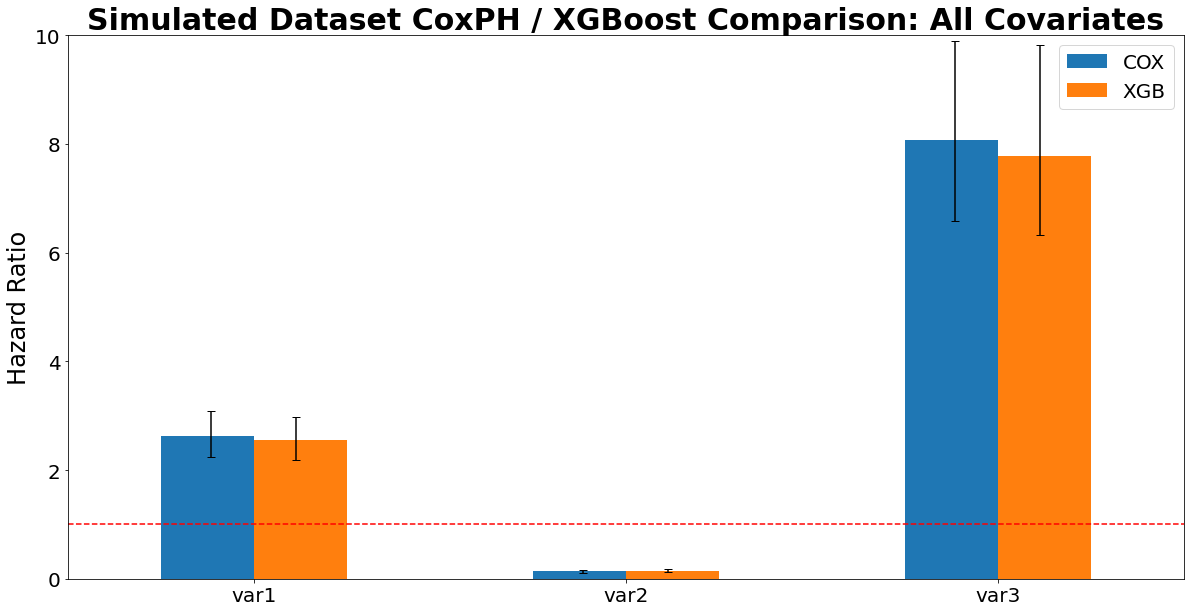

In [121]:

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]
errorsDictAll = {}

all_covs = [X_features[i] for i in range(len(X_features))]
all_covs = ['var1', 'var2', 'var3']

xgb_all_covs = [mySummaries[i] for i in range(len(X_features))]

cox_all_covs = [list_HRs_all[i] for i in range(len(X_features))]




df_cox_all = pd.DataFrame(cox_all_covs, index = all_covs, columns = ["medianHR", "LB_HR", "UB_HR"])
# print(df_cox_conts_all)
errorsCoxAll = np.array([list(df_cox_all.medianHR - df_cox_all.LB_HR),list(df_cox_all.UB_HR - df_cox_all.medianHR)])
errorsDictAll["COX"] = errorsCoxAll

df_xgb_all = pd.DataFrame(xgb_all_covs, index = all_covs, columns = ["medianHR", "LB_HR", "UB_HR"])
errorsXGBSig = np.array([list(df_xgb_all.medianHR - df_xgb_all.LB_HR),list(df_xgb_all.UB_HR - df_xgb_all.medianHR)])
errorsDictAll["XGB"] = errorsXGBSig

#All Sig Variables
total_plot_all = pd.DataFrame({"COX":list(df_cox_all.medianHR), 
                          "XGB":list(df_xgb_all.medianHR)},
                         index = all_covs)

cats = all_covs
x1 = np.arange(len(cats)) + 0.115 #offset 
x2 = np.arange(len(cats)) - 0.115 #offset
ax = total_plot_all.plot.bar(rot=0)
ax.set_title("Simulated Dataset CoxPH / XGBoost Comparison: All Covariates", fontsize = 30, weight = "heavy")
ax.axhline(y=1 , color='r', linestyle='--')
ax.set_ylabel("Hazard Ratio", fontsize = 24)
ax.set_ylim((0, 10))
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)
plt.legend(loc = 1,fontsize = 20)
plt.errorbar(x1, df_xgb_all.medianHR, yerr = errorsDictAll["XGB"], ecolor = 'black', linestyle = 'None', capsize = 4)
plt.errorbar(x2, df_cox_all.medianHR, yerr = errorsDictAll["COX"], ecolor = 'black', linestyle = 'None', capsize = 4)
plt.savefig(save_to + "cox_xgb_comparison.png",  bbox_inches = "tight", dpi = 400)

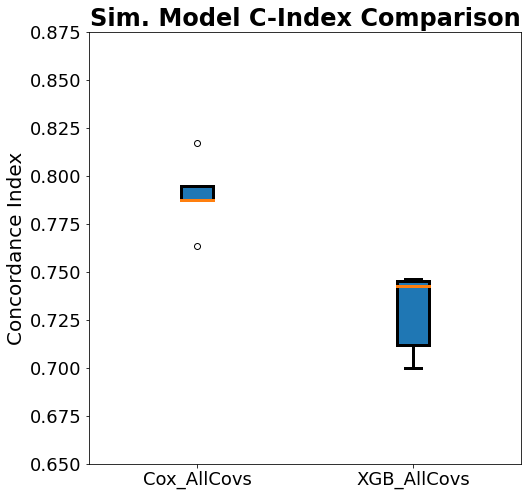

In [122]:
cox5fcv = [0.7946081, 0.7872674, 0.7634267, 0.8172029, 0.7870754]
xgb5fcv = xgb_scores

box_data = [cox5fcv, xgb5fcv]
# print(box_data)
fig = plt.figure(figsize = (6,6)) 
  
# Set the font dictionaries (for plot title and axis titles)
title_font = {'size':'24', 'color':'black', 'weight':'heavy'} # Bottom vertical alignment for more space
axis_font = {'size':'20'}
# Creating axes instance 
ax = fig.add_axes([0, 0, 1, 1]) 
ax.set_xticklabels(['Cox_AllCovs', 'XGB_AllCovs'])
ax.set_title("Sim. Model C-Index Comparison", **title_font)
ax.set_ylabel("Concordance Index", **axis_font)
ax.set_ylim(0.65, 0.875)



# for item in [ax.title]:
#     item.set_fontsize(20)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(18)

# Creating plot 
bp = ax.boxplot(box_data, patch_artist=True) 

for median in bp['medians']:
    median.set(linewidth=3)

for box in bp['boxes']:
# change outline color
    box.set(linewidth=3)

for whisker in bp['whiskers']:
    whisker.set(linewidth =3)

for cap in bp['caps']:
    cap.set(linewidth=3)

# show plot 
plt.savefig(save_to + "box_plot_sim_data.png",  bbox_inches = "tight", dpi = 400)
plt.show()

In [123]:
np.mean(xgb5fcv)

0.7289132942389053

In [125]:
np.std(xgb5fcv)

0.01940034021569278